In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import lmdb
from udls.generated import AudioExample
import IPython.display as ipd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import logging
import torchaudio
import librosa
from typing import Callable, Optional
import warnings

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s(%(name)s)\t%(message)s", level=logging.INFO
)

device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info("device: %s", device)

[2024-01-01 22:02:55,538] INFO(root)	device: cuda


In [2]:
# utils
plt.rcParams["savefig.bbox"] = "tight"


def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )

In [3]:
# dataset definition
class LoopDataset(torch.utils.data.Dataset):
    FS = 44100
    SIZE_SAMPLES = 65536

    def __init__(self, db_path: str) -> None:
        super().__init__()

        self._db_path = db_path

        self.env = lmdb.open(self._db_path, lock=False)

        with self.env.begin(write=False) as txn:
            self.keys = list(txn.cursor().iternext(values=False))

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        with self.env.begin(write=False) as txn:
            ae = AudioExample.FromString(txn.get(self.keys[idx]))

        buffer = ae.buffers["waveform"]
        assert buffer.precision == AudioExample.Precision.INT16
        assert buffer.sampling_rate == self.FS

        audio = torch.frombuffer(buffer.data, dtype=torch.int16)
        audio = audio.float() / (2**15 - 1)
        assert len(audio) == self.SIZE_SAMPLES

        return audio


# get 5 random examples
dataset = LoopDataset(db_path="../../data/loops/")
valid_ratio = 0.2
nb_valid = int(valid_ratio * len(dataset))
nb_train = len(dataset) - nb_valid
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    dataset, [nb_train, nb_valid]
)

print(nb_train, nb_valid)

num_threads = 0  # != 0 crashes on windows o_o
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_threads
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

for i in np.random.randint(len(train_dataset), size=5):
    print(f"example #{i}")
    ipd.display(ipd.Audio(train_dataset[i], rate=LoopDataset.FS))

9195 2298
example #4738


C:\Users\etian\AppData\Local\Temp\ipykernel_9796\863385641.py:27: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:1514.)
  audio = torch.frombuffer(buffer.data, dtype=torch.int16)


example #301


example #108


example #8829


example #1877


d:\Documents\ATIAM\Temporal-Audio-VAE\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


torch.Size([512, 129]) torch.Size([513, 129])


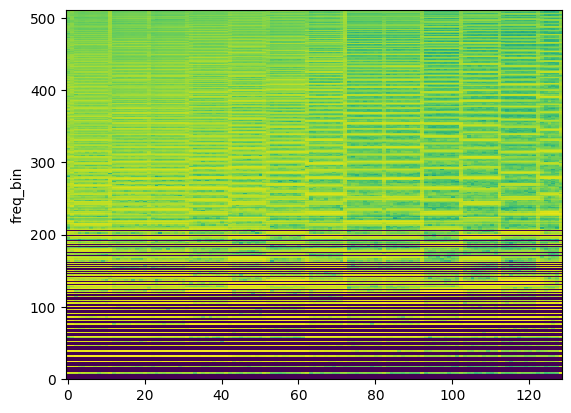

In [4]:
# transform definition


# extended from torchaudio.transform.MelSpectrogram
class CustomTransform(nn.Module):
    __constants__ = [
        "sample_rate",
        "n_fft",
        "win_length",
        "hop_length",
        "pad",
        "power",
        "normalized",
        "n_mels",
        "f_max",
        "f_min",
        "norm",
        "mel_scale",
        "n_stft",
    ]

    def __init__(
        self,
        sample_rate: int = 16000,
        n_fft: int = 400,
        win_length: Optional[int] = None,
        hop_length: Optional[int] = None,
        f_min: float = 0.0,
        f_max: Optional[float] = None,
        pad: int = 0,
        n_mels: int = 128,
        window_fn: Callable[..., torch.Tensor] = torch.hann_window,
        normalized: bool = False,
        wkwargs: Optional[dict] = None,
        center: bool = True,
        pad_mode: str = "reflect",
        norm: Optional[str] = None,
        griffin_lim_iter=32,
        griffin_lim_momentum=0.99,
    ):
        super(CustomTransform, self).__init__()

        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 2
        self.pad = pad
        self.normalized = normalized
        self.center = center
        self.n_mels = n_mels  # number of mel frequency bins
        self.f_max = f_max
        self.f_min = f_min
        self.norm = norm
        self.n_stft = self.n_fft // 2 + 1

        self.spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            pad=self.pad,
            window_fn=window_fn,
            power=None,  # get complex spectrogram
            normalized=self.normalized,
            wkwargs=wkwargs,
            center=center,
            pad_mode=pad_mode,
            onesided=True,
        )
        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=self.f_min,
            f_max=self.f_max,
            n_stft=self.n_stft,
            norm=self.norm,
            mel_scale="htk",
        )
        self.inv_mel_scale = torchaudio.transforms.InverseMelScale(
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=self.f_min,
            f_max=self.f_max,
            n_stft=self.n_stft,
            norm=self.norm,
            mel_scale="htk",
            # see https://pytorch.org/docs/stable/generated/torch.linalg.lstsq.html
            # safest option seems "gelsd", but does not work on CUDA
            # "gels" should be used (default), but it crashes because the matrix that goes in is not full rank. why ?
        )
        self.inv_spectrogram = torchaudio.transforms.InverseSpectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            pad=self.pad,
            window_fn=window_fn,
            normalized=self.normalized,
            wkwargs=wkwargs,
            center=center,
            pad_mode=pad_mode,
            onesided=True,
        )
        self.griffin_lim = torchaudio.transforms.GriffinLim(
            n_fft=self.n_fft,
            n_iter=griffin_lim_iter,
            win_length=self.win_length,
            hop_length=self.hop_length,
            window_fn=window_fn,
            power=1,  # magnitude spectrogram
            wkwargs=wkwargs,
            momentum=0.99,
        )

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        specgram = self.spectrogram(waveform)  # Dimension: (…, freq, time)
        mag, phase = torch.abs(specgram), torch.angle(specgram)
        mel_specgram = self.mel_scale(mag)  # dimension: (…, n_mels, time)
        log_mel_specgram = torch.log(1 + mel_specgram)
        return log_mel_specgram, phase

    def backward(
        self, log1p_mel_specgram: torch.Tensor, phase: torch.Tensor = None
    ) -> torch.Tensor:
        mel_specgram = torch.expm1(log1p_mel_specgram)

        # FIXME: tensor must be on cpu due to problem in inv_mel_scale :(
        # we force calculation on cpu and copy back to gpu
        self.inv_mel_scale = self.inv_mel_scale.cpu()
        device = mel_specgram.device
        mag = self.inv_mel_scale(mel_specgram.cpu())
        mag = mag.to(device)

        if phase is None:  # reconstruct phase
            # TODO: use other (better) reconstruction methods ?
            waveform = self.griffin_lim(mag)
        else:  # copy original phase
            specgram = mag * torch.exp(1j * phase)
            waveform = self.inv_spectrogram(specgram)
        return waveform

    def get_n_frames(self, n_samples: int):
        # see https://pytorch.org/docs/stable/generated/torch.stft.html
        if self.center:
            return 1 + n_samples // self.hop_length
        else:
            1 + (n_samples - self.n_fft) // self.hop_length


# test: forward then backward
ipd.display(ipd.Audio(dataset[7809], rate=LoopDataset.FS))
t = CustomTransform(
    sample_rate=LoopDataset.FS,
    n_mels=512,
    n_fft=1024,
    griffin_lim_iter=64,
).to(device)
spec, phase = t.forward(dataset[7809].to(device))
print(spec.shape, phase.shape)
plot_spectrogram(spec.cpu())
transformed_transformed_copyphase = t.backward(spec, phase)
transformed_transformed_griffinlim = t.backward(spec)
ipd.display(ipd.Audio(transformed_transformed_copyphase.cpu(), rate=LoopDataset.FS))
ipd.display(ipd.Audio(transformed_transformed_griffinlim.cpu(), rate=LoopDataset.FS))

In [5]:
# model definition
class AudioVAE(nn.Module):
    def __init__(self, n_latent, n_in):
        super(AudioVAE, self).__init__()
        n_hidden = 512
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_latent, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_in),
            nn.Sigmoid(),
        )

        self.mu = nn.Linear(n_hidden, n_latent)
        self.sigma = nn.Sequential(nn.Linear(n_hidden, n_latent), nn.Softplus())

    def encode(self, x: torch.Tensor):
        h = self.encoder(x)
        return self.mu(h), self.sigma(h)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

    def forward(self, x: torch.Tensor):
        # Encode the inputs
        mu, log_var = self.encode(x)
        # Obtain latent samples and kl divergence
        z_tilde, kl_div = self.latent(mu, log_var)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div

    def latent(self, mu: torch.Tensor, log_var: torch.Tensor):
        # reparametrization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps * std + mu

        kl_div = torch.sum(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        return z, kl_div

In [6]:
def beta_warmup(epoch, interval, epoch_interval):
    if epoch < epoch_interval[0]:
        return interval[0]
    elif epoch > epoch_interval[1]:
        return interval[1]
    return (
        (epoch - epoch_interval[0])
        * (interval[1] - interval[0])
        / (epoch_interval[1] - epoch_interval[0])
    )

In [7]:
# training loop

# parameters
n_epochs = 50
beta_interval = (0, 1)  # min, max
beta_epoch_interval = (10, 40)  # start, end
evaluate_every_nth_epoch = 3
generate_every_nth_epoch = 3
n_latent = 16
n_mels = 512
transform = CustomTransform(
    sample_rate=LoopDataset.FS,
    n_mels=n_mels,
    n_fft=1024,
    griffin_lim_iter=64,
).to(device)
n_frames = transform.get_n_frames(LoopDataset.SIZE_SAMPLES)
n_in = n_mels * n_frames

print("n_mels", n_mels)
print("n_frames", n_frames)
print("n_in", n_in)

filename = f"audiovae_{beta_interval[0]}_{beta_interval[1]}_{n_epochs}.pt"
logger.info("training %s", filename)
logger.info("n_epochs=%d", n_epochs)

model = AudioVAE(n_latent, n_in).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
recons_criterion = torch.nn.MSELoss(reduction="sum")

if Path(filename).exists():
    model.load_state_dict(torch.load(filename))
    logger.info("loaded from", filename)

else:
    WRITER = SummaryWriter(comment=filename)

    for epoch in range(n_epochs):
        beta = beta_warmup(epoch, beta_interval, beta_epoch_interval)
        logger.info(
            f"epoch {epoch+1}/{n_epochs}; beta={beta:.2f}; {epoch * len(train_dataset)} examples seen"
        )
        WRITER.add_scalar("beta", beta, epoch)

        logger.info("training")
        model.train()
        full_loss = 0
        recons_loss = 0
        kl_div = 0
        for i, waveform in tqdm(enumerate(train_loader), desc="Train"):
            optimizer.zero_grad()
            waveform = waveform.to(device)
            mag, phase = transform.forward(waveform)
            mag = mag.reshape(-1, n_in)
            mag_tilde, kl_div_batch = model(mag)
            recons_loss_batch = recons_criterion(mag_tilde, mag)
            full_loss_batch = recons_loss_batch + beta * kl_div_batch
            recons_loss += recons_loss_batch
            full_loss += full_loss_batch
            kl_div += kl_div_batch
            full_loss_batch.backward()
            optimizer.step()
        WRITER.add_scalar("loss/train/full", full_loss, epoch)
        WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
        WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)

        if epoch % evaluate_every_nth_epoch == 0 or epoch == n_epochs - 1:
            logger.info("evaluating")
            model.eval()
            full_loss = 0
            recons_loss = 0
            kl_div = 0
            for i, waveform in tqdm(enumerate(valid_loader), desc="Evaluation"):
                optimizer.zero_grad()
                waveform = waveform.to(device)
                mag, phase = transform.forward(waveform)
                mag = mag.reshape(-1, n_in)
                mag_tilde, kl_div_batch = model(mag)
                recons_loss_batch = recons_criterion(mag_tilde, mag)
                full_loss_batch = recons_loss_batch + beta * kl_div_batch
                recons_loss += recons_loss_batch
                full_loss += full_loss_batch
                kl_div += kl_div_batch
                full_loss_batch.backward()
                optimizer.step()
            WRITER.add_scalar("loss/eval/full", full_loss, epoch)
            WRITER.add_scalar("loss/eval/reconstruction", recons_loss, epoch)
            WRITER.add_scalar("loss/eval/kl_div", kl_div, epoch)

        if epoch % generate_every_nth_epoch == 0 or epoch == n_epochs - 1:
            logger.info("generating from dataset")
            with torch.no_grad():
                n_sounds = 4
                waveform = next(iter(valid_loader)).to(device)
                mag, phase = transform.forward(waveform[:n_sounds])
                mag_tilde, _ = model(mag.reshape(-1, n_in))
                mag_tilde = mag_tilde.reshape(-1, 1, n_mels, n_frames)
                grid = torchvision.utils.make_grid(mag_tilde, n_sounds)
                WRITER.add_image("gen/dataset/melspec", grid)

                waveform_tilde_copyphase = transform.backward(mag_tilde, phase)
                waveform_tilde_griffinlim = transform.backward(mag_tilde)
                WRITER.add_audio(
                    "gen/dataset/copyphase",
                    waveform_tilde_copyphase.reshape(-1),
                    epoch,
                    sample_rate=LoopDataset.FS,
                )
                WRITER.add_audio(
                    "gen/dataset/griffinlim",
                    waveform_tilde_griffinlim.reshape(-1),
                    epoch,
                    sample_rate=LoopDataset.FS,
                )

            logger.info("generating random from latent space")
            with torch.no_grad():
                n_sounds = 16
                z = torch.randn(n_sounds, n_latent).to(device)
                mag_tilde = model.decode(z).reshape(-1, 1, n_mels, n_frames)
                grid = torchvision.utils.make_grid(mag_tilde, n_sounds)
                WRITER.add_image("gen/rand_latent/melspec", grid)
                waveform_tilde = transform.backward(mag_tilde)
                WRITER.add_audio(
                    "gen/rand_latent/griffinlim",
                    waveform_tilde_griffinlim.reshape(-1),
                    epoch,
                    sample_rate=LoopDataset.FS,
                )
            logger.info("exploring latent space")
            with torch.no_grad():
                n_sounds_per_dimension = 8
                z = torch.zeros(n_sounds_per_dimension * n_latent, n_latent).to(device)
                for i in range(n_latent):
                    a = i * n_sounds_per_dimension
                    b = (i + 1) * n_sounds_per_dimension
                    z[a:b, i] = torch.linspace(-5, +5, n_sounds_per_dimension)
                mag_tilde = model.decode(z).reshape(-1, 1, n_mels, n_frames)
                grid = torchvision.utils.make_grid(mag_tilde, n_sounds_per_dimension)
                WRITER.add_image("gen/explo_latent/melspec", grid)
                waveform_tilde = transform.backward(mag_tilde)
                WRITER.add_audio(
                    "gen/explo_latent/griffinlim",
                    waveform_tilde_griffinlim.reshape(-1),
                    epoch,
                    sample_rate=LoopDataset.FS,
                )

    # save weights
    torch.save(model.state_dict(), filename)
    logger.info("saved to %s", filename)

d:\Documents\ATIAM\Temporal-Audio-VAE\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
[2024-01-01 22:02:58,673] INFO(__main__)	training audiovae_0_1_50.pt
[2024-01-01 22:02:58,674] INFO(__main__)	n_epochs=50


n_mels 512
n_frames 129
n_in 66048


[2024-01-01 22:02:59,235] INFO(__main__)	epoch 1/50; beta=0.00; 0 examples seen
[2024-01-01 22:02:59,236] INFO(__main__)	training
Train: 72it [00:05, 13.58it/s]
[2024-01-01 22:03:04,598] INFO(__main__)	evaluating
Evaluation: 18it [00:01, 14.45it/s]
[2024-01-01 22:03:05,905] INFO(__main__)	generating from dataset
[2024-01-01 22:03:06,522] INFO(__main__)	generating random from latent space
[2024-01-01 22:03:07,927] INFO(__main__)	exploring latent space
[2024-01-01 22:03:14,404] INFO(__main__)	epoch 2/50; beta=0.00; 9195 examples seen
[2024-01-01 22:03:14,448] INFO(__main__)	training
Train: 72it [00:05, 13.37it/s]
[2024-01-01 22:03:19,956] INFO(__main__)	epoch 3/50; beta=0.00; 18390 examples seen
[2024-01-01 22:03:19,957] INFO(__main__)	training
Train: 72it [00:05, 14.14it/s]
[2024-01-01 22:03:25,109] INFO(__main__)	epoch 4/50; beta=0.00; 27585 examples seen
[2024-01-01 22:03:25,109] INFO(__main__)	training
Train: 72it [00:05, 14.09it/s]
[2024-01-01 22:03:30,278] INFO(__main__)	evaluating

RuntimeError: false INTERNAL ASSERT FAILED at "..\\aten\\src\\ATen\\native\\BatchLinearAlgebra.cpp":1540, please report a bug to PyTorch. torch.linalg.lstsq: Argument 6 has illegal value. Most certainly there is a bug in the implementation calling the backend library.